In [1]:
import torch
import torchvision
from torch import nn
import collections
from d2l import torch as d2l
from torch.utils.data import DataLoader
import math
import shutil
import pandas as pd
import os

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Adapted from d2l
def get_model():
  return torchvision.models.vision_transformer.vit_b_16()
loss = nn.CrossEntropyLoss(reduction='none')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def train(net, train_dataloader, valid_dataloader, num_epochs, lr, weight_decay, lr_period, lr_decay):
  trainer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  
  net.to(device)
  legend = ['train_loss', 'train_acc']
  if valid_dataloader is not None:
    legend.append('valid_acc')

  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 3], legend=legend)
  for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    valid_acc = 0
    num_train_examples = 0
    num_valid_examples = 0

    for i, (X, Y) in enumerate(train_dataloader):
      X, Y = X.to(device), Y.to(device)
      # Set to train mode
      net.train()
      # Zero out gradients
      trainer.zero_grad()
      # Backward prop
      Y_hat = net(X)
      l = loss(Y_hat, Y)
      l.sum().backward()

      # Update trainer and lr_scheduler
      trainer.step()

      # Update stats
      num_train_examples += X.shape[0]
      train_loss += l.sum().detach().cpu().numpy()
      train_acc += d2l.accuracy(Y_hat, Y)
      animator.add(epoch + 1 + i / len(train_dataloader), (train_loss / num_train_examples, train_acc / num_train_examples, None))


    if valid_dataloader is not None:
      for i, (X, Y) in enumerate(valid_dataloader):
        X, Y = X.to(device), Y.to(device)
        net.eval()
        num_valid_examples += X.shape[0]
        Y_hat = net(X.to(device))
        valid_acc += d2l.accuracy(Y_hat, Y)
      animator.add(epoch + 1 + i / len(valid_dataloader), (None, None, valid_acc / len(valid_dataloader)))

    scheduler.step()
    
      


    
      

In [4]:
def load_labels(batch_size=64):
  with open('./data/trainLabels.csv', 'r') as f:
    lines = f.readlines()[1:]
  
  tokens = [l.rstrip().split(',') for l in lines]
  return dict((name, label) for name, label in tokens)


In [5]:
data_dir = './data'
labels = load_labels()

In [35]:
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def sort_train_validation_data(data_dir, labels, valid_ratio = 0.1):
  n = collections.Counter(labels.values()).most_common()[-1][1]
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_img in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_img.split('.')[0]]
    f = os.path.join(data_dir, 'train', train_img)
    copyfile(f, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))

    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(f, os.path.join(data_dir, 'train_valid_test', 'train', label))
    else:
      copyfile(f, os.path.join(data_dir, 'train_valid_test', 'valid', label))

    if label not in label_count:
      label_count[label] = 0
    label_count[label] += 1

In [7]:
def sort_test_data(data_dir):
  for test_img in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(os.path.join(data_dir, 'test', test_img), os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [8]:
sort_train_validation_data(data_dir, labels)
sort_test_data(data_dir)

NameError: name 'sort_train_validation_data' is not defined

In [6]:
train_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((256, 256)),
  torchvision.transforms.RandomResizedCrop(224, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])
test_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])
train_data, train_valid_data = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=train_transform) for folder in ['train', 'train_valid']]
valid_data, test_data = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=test_transform) for folder in ['valid', 'test']]

In [8]:
batch_size = 32
train_dataloader, train_valid_dataloader = [DataLoader(data, batch_size=batch_size, shuffle=True) for data in [train_data, train_valid_data]]
valid_dataloader, test_dataloader = [DataLoader(data, batch_size=batch_size, shuffle=False) for data in [valid_data, test_data]]

In [9]:
# Hyperparams
lr = 2e-4
num_epochs=20
weight_decay=5e-4
lr_period=4
lr_decay=0.9

OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 7.01 GiB is allocated by PyTorch, and 241.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

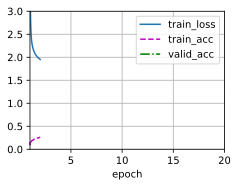

In [10]:
train(get_model(), train_dataloader, valid_dataloader, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, lr_period=lr_period, lr_decay=lr_decay)

In [44]:
# Training with full train
net = get_model()
train(net, train_valid_dataloader, None, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, lr_period=lr_period, lr_decay=lr_decay)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 7.22 GiB is allocated by PyTorch, and 69.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
# Evaluation
predictions = []
def eval_test():
  for X, _ in test_dataloader:
    net.eval()
    Y_hat = net(X.to(device))
    predictions.extend(Y_hat.argmax(dim = 1).type(torch.int32).cpu().numpy())

eval_test()
labels = list(map(lambda idx: train_valid_data.classes[idx], predictions))

In [16]:
ids = list(range(1, len(test_data) + 1))
ids.sort(key = lambda x: str(x))
ans = pd.DataFrame({'id': ids, 'label': labels})
ans.to_csv('submission.csv', index=False)

In [45]:
print(collections.Counter(predictions))

Counter({6: 46021, 4: 41538, 0: 33793, 9: 30124, 8: 29186, 3: 29184, 1: 24923, 2: 22991, 7: 22537, 5: 19703})


In [ ]:
print(train_valid_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


: 